In [1]:
from pandas import DataFrame, Series, read_csv, concat
import numpy as np
import re
#from ggplot import *
import matplotlib.pyplot as plt
import os


In [2]:
#Set working directory
#os.chdir( 'D:/projects/Sara Marcos' )    #.... changing directory
os.chdir( '/Users/Sara/Desktop/PythonProj/Chartbeat_py' ) 

#We load the data
charbeat = DataFrame.from_csv('RawData/Chartbeat.csv', index_col=None)

/Users/Sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


In [3]:
#store column header names
col_names = charbeat.columns.values


In [4]:
#create data series for column author
charbeat_author = Series(charbeat['author'])
#charbeat_author

In [5]:
#Remove special characters (everything that's not alpha type)
charbeat_author = charbeat_author.str.replace('[^a-zA-Z]', ' ')


In [6]:
#Removing any extra white space
charbeat_author = charbeat_author.str.replace('[\\s]+', ' ')
charbeat_author = charbeat_author.str.replace('(\\w\\w)\\W+\\w\\W+(\\w\\w)', '\\1 \\2')

charbeat['author'] = charbeat_author


In [7]:
#Ordening authors by A-Z order
charbeat = charbeat.sort_values("author", ascending = True, kind='quicksort')


In [8]:
#Looking for similarity
#If in row 1 we have Sara Marcos and row 2 we have Sara Marcos p. They are similar
#If they are similar, row 2 Sara Marcos p is now Sara Marcos
#this part takes 10sec
for i in range(0,len(charbeat)-1):
	if charbeat.iloc[i,0] == charbeat.iloc[i+1,0]:
		charbeat.iloc[i+1,0] = charbeat.iloc[i,0]


In [9]:
#remove duplicated articles
charbeat = charbeat.drop_duplicates(subset="path",keep='first', inplace=False)


In [10]:
#Total unique authors
unique_authors = charbeat.drop_duplicates(subset="author",keep='first', inplace=False)['author']


In [11]:
#create new dataframe with only path column
charbeat_path = DataFrame(charbeat["path"], index=charbeat.index.values, columns=['path'])


In [12]:
#create new dataframe from splited article column
broken_down_path = DataFrame(charbeat_path['path'].str.split('/').tolist(), columns = ["a","topic","subtopic","d","e","f","g"], index=charbeat.index.values)

#Q - in R i had c and d 

In [13]:
#add broken-down path to the main set
charbeat = charbeat.drop('path', 1)
charbeat = concat([charbeat,broken_down_path], axis=1, join='inner')



In [14]:
#charbeat

In [15]:
#if topic is empty, delete row
for i in range(len(charbeat)):
	if charbeat.iloc[i,7] == None:
		charbeat.drop(i)

In [16]:
#Aggregate variables
#total page views per author (all post included)
pageviews = Series(charbeat.groupby('author').page_views.sum(), name="pageviews")

#Q - order from big to small and add percentages?

In [17]:
#Av page views
#av page views per author per post
avpageviews = Series(charbeat.groupby('author').page_views.mean(), name="avpageviews")

#round 2 decimals, order from bigger to smaller and add percentage. 

In [18]:
#Loyal 
#total loyal readers per author (all post included)
loyal = Series(charbeat.groupby('author').page_views_loyal.sum(), name="loyal")

avloyal = Series(charbeat.groupby('author').page_views_loyal.mean(), name="avloyal")

#round 2 decimals, order from bigger to smaller and add percentage. 

In [19]:
#Time 
#total time spending reading per author (all post included)
totaltime=Series(charbeat.groupby('author').page_total_time.sum(), name="totaltime")

#round 2 decimals, order from bigger to smaller and add percentage. 

In [20]:
#quality view
#total page views per quality readers per author (all post included)
quality = Series(charbeat.groupby('author').page_views_quality.sum(), name="quality")

#round 2 decimals, order from bigger to smaller and add percentage. 

In [21]:
#av quality 
#av page views quality readers per author per post
avquality = Series(charbeat.groupby('author').page_views_quality.mean(), name="avquality")

#round 2 decimals, order from bigger to smaller and add percentage. 

In [22]:
#all together
newdf = concat([pageviews, loyal, totaltime, quality, avpageviews, avloyal, avquality], axis=1)
newdf.reset_index(level=0, inplace=True)

#order by higher avpageviews

In [23]:
#We will work with authors where page_views >9  do not damage (a lot) the ratio calculation
# 9 it is the first 25% od the data
#Remove papas mamas it is a category not an author

newdf = newdf.query('pageviews > 9')
newdf = newdf[newdf.author != "papas mamas"]


In [24]:
####################
#New variables
newdf['loyal_reader_rate'] = (newdf['loyal']/newdf['pageviews']).round(2)
newdf['quality_reader_rate'] = (newdf['quality']/newdf['pageviews']).round(2)
newdf['aggregate_average_time'] = (newdf['totaltime']/newdf['pageviews']).round(2)


In [25]:
#correlations, stored in cariables but they are not passed yet
cor_loyal_quality = newdf['loyal_reader_rate'].corr(newdf['quality_reader_rate'])
cor_loyal_avtime = newdf['loyal_reader_rate'].corr(newdf['aggregate_average_time'])
cor_quality_avtime = newdf['aggregate_average_time'].corr(newdf['quality_reader_rate'])


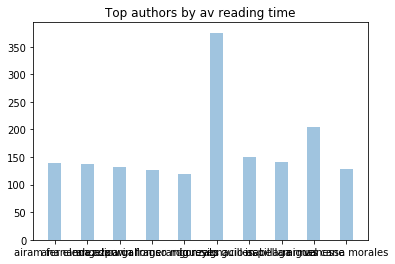

In [26]:
#top 10 authros by average reading time

# in R i had a loop - can it be done in python? all these lines of code occupy a lot of space and could be optimized witha loop like it was in R ?
rankingtime = DataFrame(newdf[['author', 'aggregate_average_time']]).sort_values('aggregate_average_time', ascending=False).head(10)
plt.bar(rankingtime['author'], rankingtime['aggregate_average_time'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by av reading time")
plt.show()

#can the graph be ordered from bigger to smaller?

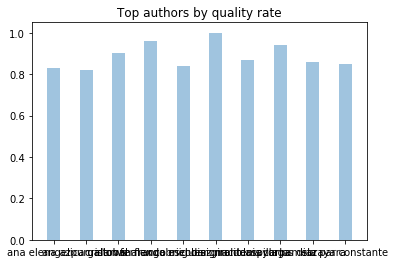

In [27]:
qualitytime = DataFrame(newdf[['author', 'quality_reader_rate']]).sort_values('quality_reader_rate', ascending=False).head(10)
#qualitytimeplot = ggplot(aes(x='author', y='quality_reader_rate'), data=qualitytime) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top authors by quality rate")
plt.bar(qualitytime['author'], qualitytime['quality_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by quality rate")
plt.show()

#can the graph be ordered from bigger to smaller?


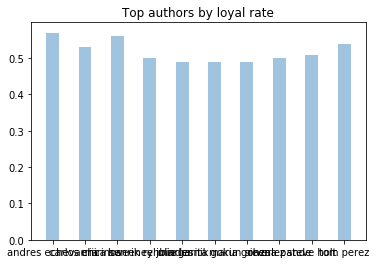

In [28]:
loyaltime = DataFrame(newdf[['author', 'loyal_reader_rate']]).sort_values('loyal_reader_rate', ascending=False).head(10)
#loyaltimeplot = ggplot(aes(x='author', y='loyal_reader_rate'), data=loyaltime) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top authors by loyal rate")
plt.bar(loyaltime['author'], loyaltime['loyal_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by loyal rate")
plt.show()

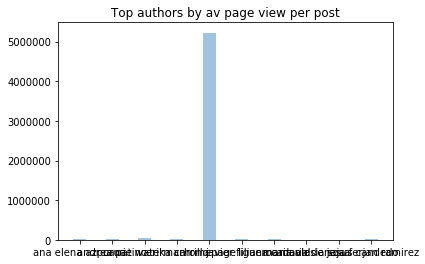

In [29]:
#First ten author with higher av of page views in their posting
avpagev = DataFrame(newdf[['author', 'avpageviews']]).sort_values('avpageviews', ascending=False).head(10)
#avpagevplot = ggplot(aes(x='author', y='avpageviews'), data=avpagev) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top authors by av page view per post")
plt.bar(avpagev['author'], avpagev['avpageviews'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by av page view per post")
plt.show()


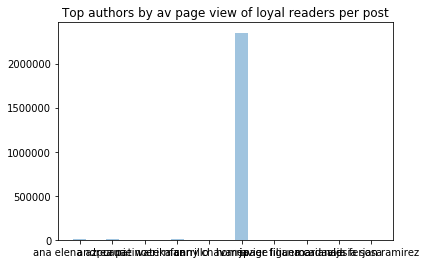

In [30]:
#First ten author with higher av page views of loyal readers in their posting
avpageloyal = DataFrame(newdf[['author', 'avloyal']]).sort_values('avloyal', ascending=False).head(10)
#avpageloyalplot = ggplot(aes(x='author', y='avloyal'), data=avpageloyal) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top authors by av page view of loyal readers per post")
plt.bar(avpageloyal['author'], avpageloyal['avloyal'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by av page view of loyal readers per post")
plt.show()

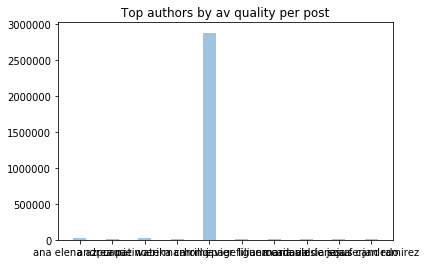

In [31]:
#First ten author with higher av page views of loyal readers in their posting
avquality = DataFrame(newdf[['author', 'avquality']]).sort_values('avquality', ascending=False).head(10)
#avqualityplot = ggplot(aes(x='author', y='avquality'), data=avquality) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top authors by av quality per post")
plt.bar(avquality['author'], avquality['avquality'], 0.2/0.5, color="#A0C4DF")
plt.title("Top authors by av quality per post")
plt.show()


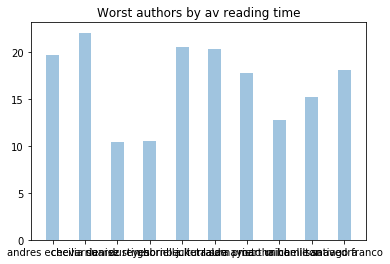

In [32]:
#WORST 10
worstrankingtime = DataFrame(newdf[['author', 'aggregate_average_time']]).sort_values('aggregate_average_time', ascending=True).head(10)
#worstrankingtimeplot = ggplot(aes(x='author', y='aggregate_average_time'), data=worstrankingtime) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by av reading time")
plt.bar(worstrankingtime['author'], worstrankingtime['aggregate_average_time'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by av reading time")
plt.show()

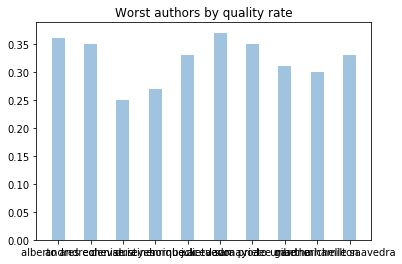

In [33]:
worstqualitytime = DataFrame(newdf[['author', 'quality_reader_rate']]).sort_values('quality_reader_rate', ascending=True).head(10)
#worstqualitytimeplot = ggplot(aes(x='author', y='quality_reader_rate'), data=worstqualitytime) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by quality rate")
plt.bar(worstqualitytime['author'], worstqualitytime['quality_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by quality rate")
plt.show()

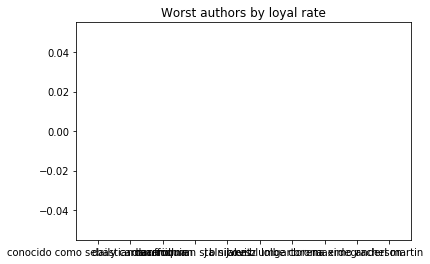

In [34]:
worstloyaltime = DataFrame(newdf[['author', 'loyal_reader_rate']]).sort_values('loyal_reader_rate', ascending=True).head(10)
#worstloyaltimeplot = ggplot(aes(x='author', y='loyal_reader_rate'), data=worstloyaltime) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by loyal rate")
plt.bar(worstloyaltime['author'], worstloyaltime['loyal_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by loyal rate")
plt.show()


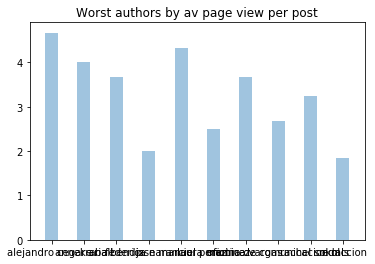

In [35]:
#Worst ten author with higher av of page views in their posting
wavpagev = DataFrame(newdf[['author', 'avpageviews']]).sort_values('avpageviews', ascending=True).head(10)
#wavpagevplot = ggplot(aes(x='author', y='avpageviews'), data=wavpagev) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by av page view per post")
plt.bar(wavpagev['author'], wavpagev['avpageviews'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by av page view per post")
plt.show()



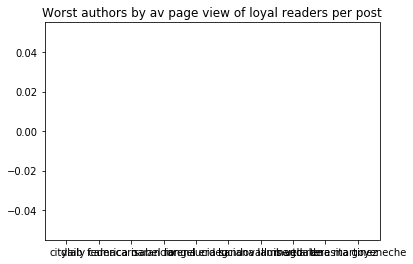

In [36]:
#Worst ten author with higher av page views of loyal readers in their posting
wavpageloyal = DataFrame(newdf[['author', 'avloyal']]).sort_values('avloyal', ascending=True).head(10)
#wavpageloyalplot = ggplot(aes(x='author', y='avloyal'), data=wavpageloyal) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by av page view of loyal readers per post")
plt.bar(wavpageloyal['author'], wavpageloyal['avloyal'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by av page view of loyal readers per post")
plt.show()

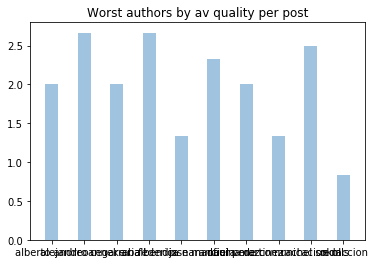

In [37]:
#Worst ten author with higher av page views of loyal readers in their posting
wavquality = DataFrame(newdf[['author', 'avquality']]).sort_values('avquality', ascending=True).head(10)
#wavqualityplot = ggplot(aes(x='author', y='avquality'), data=wavquality) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst authors by av quality per post")
plt.bar(wavquality['author'], wavquality['avquality'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst authors by av quality per post")
plt.show()

In [38]:
####

#TOPIC PART
#create data series for column author
charbeat_topic = Series(charbeat['topic'])
charbeat_subtopic = Series(charbeat['subtopic'])

In [39]:
#Remove special characters (everything that's not alpha type)
charbeat_topic = charbeat_topic.str.replace('[^a-zA-Z]', ' ')
charbeat_subtopic = charbeat_subtopic.str.replace('[^a-zA-Z]', ' ')
charbeat_topic = charbeat_topic.str.replace("[^a-zA-Z\\s]", " ")
charbeat_subtopic = charbeat_subtopic.str.replace("[^a-zA-Z\\s]", " ")
charbeat_subtopic = charbeat_subtopic.str.replace('-', ' ')
charbeat_topic = charbeat_topic.str.replace("(\\w\\w)\\W+\\w\\W+(\\w\\w)", "\\1 \\2")
charbeat_subtopic = charbeat_subtopic.str.replace("(\\w\\w)\\W+\\w\\W+(\\w\\w)", "\\1 \\2")



In [40]:
charbeat['topic'] = charbeat_topic
charbeat['subtopic'] = charbeat_subtopic

In [41]:
#Ordening authors by A-Z order
charbeat = charbeat.sort_values("topic", ascending = True, kind='quicksort')



In [42]:
#cleaning and aggregating horoscopes
for i in range(len(charbeat)):
	if charbeat.topic.iloc[i] == "es":
		charbeat.topic[i] = "deportes"

subtopiclist = ["acuario", "piscis", "aries", "tauro", "geminis",
 "cancer", "leo", "virgo", "libra", "escorpion",
  "sagitario", "capricornio", "predicciones horoscopo",
   "predicciones ano nuevo","horoscopo chino", "horoscopos-cancer",
    "horoscopo-diario", "predicciones-horoscopos", "horoscopo-chino"]

for i in range(len(charbeat)):
	if charbeat.subtopic.iloc[i] in subtopiclist:
		charbeat.subtopic[i] = "horoscopo"



/Users/Sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
#Looking for similarity
#If in row 1 we have sara marcos and row 2 we have sara marcos p. They are similar
#If they are similar, row 2 sara marcos p is now sara marcos

for i in range(0,len(charbeat)-1):
	if charbeat.iloc[i,8] == charbeat.iloc[i+1,8]:
		charbeat.iloc[i+1,8] = charbeat.iloc[i,8]


In [44]:
cities = [ "atlanta","arizona","austin","chicago","dallas","fresno","houston","las vegas", "los angeles","miami","north carolina","nueva york", "puerto rico", "sacramento", "san antonio","san diego","san francisco", "san francsico","philadelphia" ]


In [45]:
charbeat['city'] = charbeat.topic

for i in range(len(charbeat)):
	if charbeat.iloc[i,8] in cities:
		charbeat.iloc[i,8] = charbeat.iloc[i,10]
		charbeat.iloc[i,9] = charbeat.iloc[i,11]

#for i in range(len(charbeat)):
#	if charbeat.iloc[i,8] in cities:
#		charbeat.iloc[i,9] = charbeat.iloc[i,11]

#if city is in subtopic then change subtopic to e
#.iloc[x,y] returns row number x and column number y (like a matrix)

        

In [46]:
charbeat

,author,page_avg_scroll,page_avg_time,page_total_time,page_views,page_views_loyal,page_views_quality,a,topic,subtopic,d,e,f,g,city
4730,homepage,4050,38,202810485,5224072,2350640,2879999,,,None,None,None,None,None,
3766,paula diaz,4333,83,1494,18,9,11,,noticias,planeta,noticias,planeta,demandan-al-gobierno-de-trump-para-que-estudie...,None,arizona
5551,paula diaz,3833,2,2,1,0,0,,noticias,consulados,noticias,consulados,inmigrantes-mexicanos-en-estados-unidos-contar...,None,arizona
251,vanessa morales,9217,216,1300,6,0,6,,entretenimiento,pedro-infante-asi-fue-el-accidente-que-impidio...,entretenimiento,pedro-infante-asi-fue-el-accidente-que-impidio...,None,None,arizona
6045,paula diaz,3726,59,948,16,0,11,,noticias,investigacion,noticias,investigacion,el-laboratorio-biosphere-2-replica-el-ecosiste...,None,arizona
6702,univision com,3589,50,14089,278,3,205,,estilo-de-vida,viajes,estilo-de-vida,viajes,la-magia-del-parque-nacional-yosemite-en-invierno,None,arizona
4436,paula diaz,4123,40,203,5,0,3,,noticias,indocumentados,noticias,indocumentados,organizacion-humanitaria-encuentra-restos-en-e...,None,arizona
2030,paula diaz,5221,42,299,7,0,4,,noticias,custodia-de-menores,noticias,custodia-de-menores,una-madre-de-arizona-afirma-que-perdio-custodi...,None,arizona
1900,daniela zavala,5341,118,7608,64,1,45,,noticias,desapariciones,noticias,desapariciones,padre-regresa-al-gran-canon-con-la-esperanza-d...,None,arizona
226,daniela zavala,9433,45,504,11,0,8,,noticias,medio-ambiente,noticias,medio-ambiente,dia-de-la-tierra-20-maravillas-de-nuestro-plan...,None,arizona


In [47]:
####################
#Creating variables
pageviewstopic = Series(charbeat.groupby('topic').page_views.sum(), name="pageviews")
avpageviewstopic = Series(charbeat.groupby('topic').page_views.mean(), name="av.pages.views")
loyaltopic = Series(charbeat.groupby('topic').page_views_loyal.sum(), name="page_views_loyal")
avloyaltopic = Series(charbeat.groupby('topic').page_views_loyal.mean(), name="av.page_views_loyal")
totaltimetopic = Series(charbeat.groupby('topic').page_total_time.sum(), name="page_total_time")
qualitytopic = Series(charbeat.groupby('topic').page_views_quality.sum(), name="page_views_quality")
avqualitytopic = Series(charbeat.groupby('topic').page_views_quality.mean(), name="av.quality")



In [48]:
newdftopic = concat([pageviewstopic, avpageviewstopic, loyaltopic, avloyaltopic, totaltimetopic, qualitytopic, avqualitytopic], axis=1)


In [49]:
newdftopic.reset_index(level=0, inplace=True)

In [50]:
newdftopic['loyal_reader_rate'] = (newdftopic['page_views_loyal']/newdftopic['pageviews']).round(2)
newdftopic['quality_reader_rate'] = (newdftopic['page_views_quality']/newdftopic['pageviews']).round(2)
newdftopic['aggregate_average_time'] = (newdftopic['page_total_time']/newdftopic['pageviews']).round(2)


In [51]:
newdftopic

,topic,pageviews,av.pages.views,page_views_loyal,av.page_views_loyal,page_total_time,page_views_quality,av.quality,loyal_reader_rate,quality_reader_rate,aggregate_average_time
0,,5224072,5.224072e+06,2350640,2.350640e+06,202810485,2879999,2.879999e+06,0.45,0.55,38.82
1,abrira-primer-cat-cafe-al-estilo-japones-en-ma...,1,1.000000e+00,0,0.000000e+00,36,1,1.000000e+00,0.00,1.00,36.00
2,accidentes-de-transporte,3,3.000000e+00,0,0.000000e+00,107,2,2.000000e+00,0.00,0.67,35.67
3,asi-es-el-recorrido-por-el-festival-de-luces-n...,2874,2.874000e+03,440,4.400000e+02,97895,1514,1.514000e+03,0.15,0.53,34.06
4,borron-y-cuenta-nueva,6,6.000000e+00,0,0.000000e+00,192,4,4.000000e+00,0.00,0.67,32.00
5,cinco-cosas-que-quizas-no-sabias-del-festival-...,8,8.000000e+00,0,0.000000e+00,657,5,5.000000e+00,0.00,0.62,82.12
6,comunidad,35,1.750000e+01,0,0.000000e+00,1235,18,9.000000e+00,0.00,0.51,35.29
7,cuales-son-los-7-errores-mas-comunes-que-comet...,135,1.350000e+02,1,1.000000e+00,6181,93,9.300000e+01,0.01,0.69,45.79
8,deportes,7247,1.697190e+01,272,6.370023e-01,418294,4640,1.086651e+01,0.04,0.64,57.72
9,dos-enamorados-de-miami-para-contarte-lo-que-p...,6,6.000000e+00,0,0.000000e+00,242,3,3.000000e+00,0.00,0.50,40.33


In [52]:
#We see how many post exists for topic
topic_abs_fre = Series(charbeat.groupby('topic').topic.count(), name="topicfre")
totalfreq = topic_abs_fre.sum()
topic_rel_fre = topic_abs_fre/totalfreq

#sorted frequences
topic_abs_fre = Series(charbeat.groupby('topic').topic.count(), name="topicfre").sort_values(ascending=False)

In [53]:
topic_abs_fre

topic
noticias                                                                                     4938
estilo de vida                                                                               1112
entretenimiento                                                                               531
deportes                                                                                      427
musica                                                                                        279
univision news                                                                                195
especiales                                                                                     59
shows                                                                                          49
personas                                                                                       36
test                                                                                           24
estilo-de-vida

In [54]:
#We filter topics with more that 5.25 post (we remove the 25% of the topics with low posts)
topic_abs_fre = topic_abs_fre[topic_abs_fre > 5.25] 


In [55]:
#We do a inner join between our data in newdftopic 
#topics with number of post bigger than 5.25. This will delete the otheir topics
newdftopic = newdftopic.join(topic_abs_fre, how='inner', on='topic')


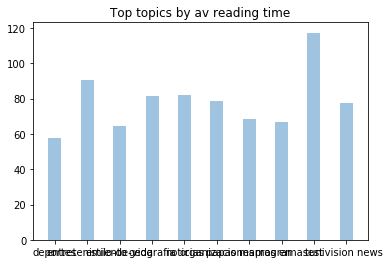

In [56]:
rankingtimetopic = DataFrame(newdftopic[['topic', 'aggregate_average_time']]).sort_values('aggregate_average_time', ascending=False).head(10)
#rankingtimetopicplot = ggplot(aes(x='topic', y='aggregate_average_time'), data=rankingtimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by av reading time")
plt.bar(rankingtimetopic['topic'], rankingtimetopic['aggregate_average_time'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by av reading time")
plt.show()


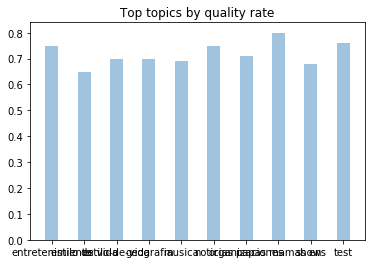

In [59]:
qualitytimetopic = DataFrame(newdftopic[['topic', 'quality_reader_rate']]).sort_values('quality_reader_rate', ascending=False).head(10)
#qualitytimetopicplot = ggplot(aes(x='topic', y='quality_reader_rate'), data=qualitytimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by quality rate")
plt.bar(qualitytimetopic['topic'], qualitytimetopic['quality_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by quality rate")
plt.show()

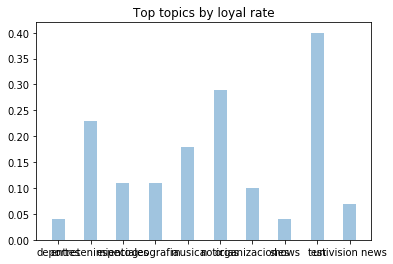

In [60]:
loyaltimetopic = DataFrame(newdftopic[['topic', 'loyal_reader_rate']]).sort_values('loyal_reader_rate', ascending=False).head(10)
#loyaltimetopicplot = ggplot(aes(x='topic', y='loyal_reader_rate'), data=loyaltimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by loyal rate")
plt.bar(loyaltimetopic['topic'], loyaltimetopic['loyal_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by loyal rate")
plt.show()

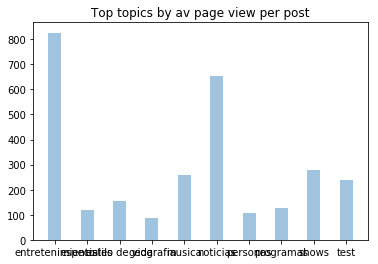

In [61]:
#First ten topics with higher av of page views in their posting
avpagevtopic = DataFrame(newdftopic[['topic', 'av.pages.views']]).sort_values('av.pages.views', ascending=False).head(10)
#avpagevtopicplot = ggplot(aes(x='topic', y='av.pages.views'), data=avpagevtopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by av page view per post")
plt.bar(avpagevtopic['topic'], avpagevtopic['av.pages.views'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by av page view per post")
plt.show()

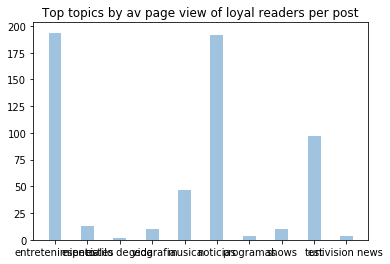

In [62]:
#First ten topics with higher av page views of loyal readers in their posting
avpageloyaltopic = DataFrame(newdftopic[['topic', 'av.page_views_loyal']]).sort_values('av.page_views_loyal', ascending=False).head(10)
#avpageloyaltopicplot = ggplot(aes(x='topic', y='av.page_views_loyal'), data=avpageloyaltopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by av page view of loyal readers per post")
plt.bar(avpageloyaltopic['topic'], avpageloyaltopic['av.page_views_loyal'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by av page view of loyal readers per post")
plt.show()

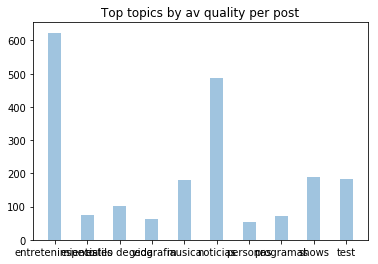

In [63]:
#First ten topics with higher av page views of loyal readers in their posting
avqualitytopic = DataFrame(newdftopic[['topic', 'av.quality']]).sort_values('av.quality', ascending=False).head(10)
#avqualitytopicplot = ggplot(aes(x='topic', y='av.quality'), data=avqualitytopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Top topics by av quality per post")
plt.bar(avqualitytopic['topic'], avqualitytopic['av.quality'], 0.2/0.5, color="#A0C4DF")
plt.title("Top topics by av quality per post")
plt.show()

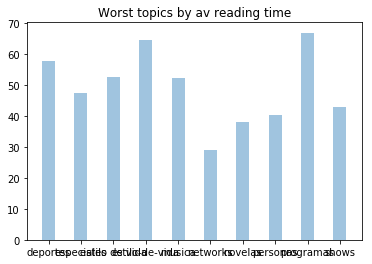

In [72]:
#WORST 10

#Worst 10 authors by average reading time
worstrankingtimetopic = DataFrame(newdftopic[['topic', 'aggregate_average_time']]).sort_values('aggregate_average_time', ascending=True).head(10)
#worstrankingtimetopicplot = ggplot(aes(x='topic', y='aggregate_average_time'), data=worstrankingtimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by av reading time")
plt.bar(worstrankingtimetopic['topic'], worstrankingtimetopic['aggregate_average_time'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by av reading time")
plt.show()

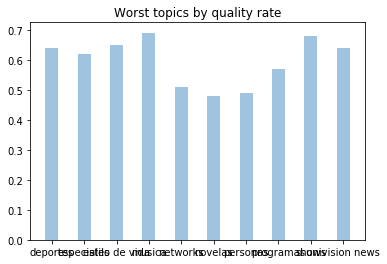

In [73]:
worstqualitytimetopic = DataFrame(newdftopic[['topic', 'quality_reader_rate']]).sort_values('quality_reader_rate', ascending=True).head(10)
#worstqualitytimetopicplot = ggplot(aes(x='topic', y='quality_reader_rate'), data=worstqualitytimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by quality rate")
plt.bar(worstqualitytimetopic['topic'], worstqualitytimetopic['quality_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by quality rate")
plt.show()


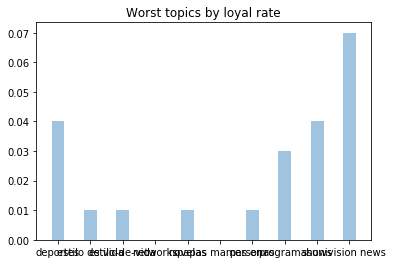

In [74]:
worstloyaltimetopic = DataFrame(newdftopic[['topic', 'loyal_reader_rate']]).sort_values('loyal_reader_rate', ascending=True).head(10)
#worstloyaltimetopicplot = ggplot(aes(x='topic', y='loyal_reader_rate'), data=worstloyaltimetopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by loyal rate")
plt.bar(worstloyaltimetopic['topic'], worstloyaltimetopic['loyal_reader_rate'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by loyal rate")
plt.show()

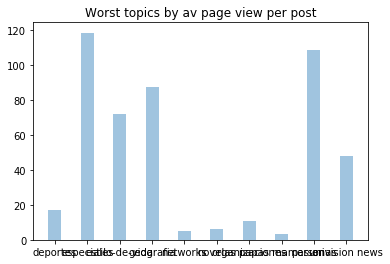

In [75]:
#Worst ten author with higher av of page views in their posting
wavpagevtopic = DataFrame(newdftopic[['topic', 'av.pages.views']]).sort_values('av.pages.views', ascending=True).head(10)
#wavpagevtopicplot = ggplot(aes(x='topic', y='av.pages.views'), data=wavpagevtopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by av page view per post")
plt.bar(wavpagevtopic['topic'], wavpagevtopic['av.pages.views'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by av page view per post")
plt.show()

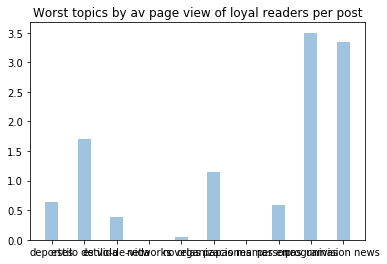

In [76]:
#Worst ten author with higher av page views of loyal readers in their posting
wavpageloyaltopic = DataFrame(newdftopic[['topic', 'av.page_views_loyal']]).sort_values('av.page_views_loyal', ascending=True).head(10)
#wavpageloyaltopicplot = ggplot(aes(x='topic', y='av.page_views_loyal'), data=wavpageloyaltopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by av page view of loyal readers per post")
plt.bar(wavpageloyaltopic['topic'], wavpageloyaltopic['av.page_views_loyal'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by av page view of loyal readers per post")
plt.show()

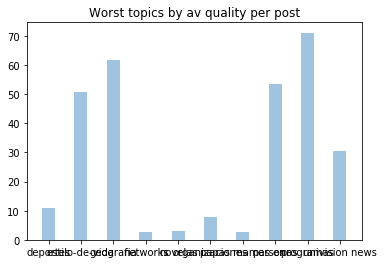

In [78]:
#Worst ten author with higher av page views of loyal readers in their posting
wavqualitytopic = DataFrame(newdftopic[['topic', 'av.quality']]).sort_values('av.quality', ascending=True).head(10)
#wavqualitytopicplot = ggplot(aes(x='topic', y='av.quality'), data=wavqualitytopic) + geom_bar(fill="#A0C4DF", stat= 'identity') + ggtitle("Worst topics by av quality per post")
plt.bar(wavqualitytopic['topic'], wavqualitytopic['av.quality'], 0.2/0.5, color="#A0C4DF")
plt.title("Worst topics by av quality per post")
plt.show()
